In [46]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc as pm
import xarray as xr

from pymc import  Model, Normal, sample

In [2]:
import numpy as np

def w(r_array, args=[5,15,2,1]):
    t = args[0]
    L = args[1]
    T = args[2]
    rho = args[3]
    w_values = np.zeros_like(r_array)  # Initialize an array of the same size as r_array
    
    # Case 1: r <= t / 2
    mask1 = (r_array <= t / 2)
    w_values[mask1] = 4 * (T * r_array[mask1])**2
    
    # Case 2: t / 2 <= r < t
    mask2 = (r_array >= t / 2) & (r_array < t)
    w_values[mask2] = (T * t)**2 + T * (r_array[mask2] - (t / 2))
    
    # Case 3: t < r < L
    mask3 = (r_array >= t) & (r_array < L)
    w_values[mask3] = (T * t)**2 + (T * (t / 2)) + rho * (r_array[mask3] - t)
    
    # Case 4: r >= L
    mask4 = (r_array >= L)
    w_values[mask4] = (T * t)**2 + (T * (t / 2)) + rho * (L - t)
    
    return w_values

# Example usage:
r_array = np.arange(0,20)  # Example input array for r
# t = 5  # Example constant
# L = 15  # Example constant
# T = 2  # Example constant
# rho = 1  # Example constant

w_values = w(r_array)
print("w(r) values:", w_values)


w(r) values: [  0  16  64 101 103 105 106 107 108 109 110 111 112 113 114 115 115 115
 115 115]


In [47]:
import numpy as np
def w(r, args=[5,15,2,1]):
    t = args[0]
    L = args[1]
    T = args[2]
    rho = args[3]

    # Case 1: r <= t / 2
    if r <= t / 2:
        return 4 * (T * r)**2
    
    # Case 2: t / 2 <= r < t
    elif r >= t / 2 and r< t :
        return (T * t)**2 + T * (r - (t / 2))
    
    # Case 3: t < r < L
    elif r >= t and r < L:
        return (T * t)**2 + (T * (t / 2)) + rho * (r - t)
    
    # Case 4: r >= L
    else:
        return  (T * t)**2 + (T * (t / 2)) + rho * (L - t)

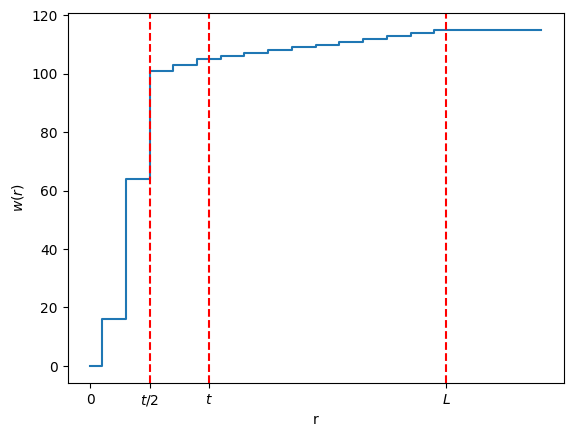

In [3]:
args=[5,15,2,1]
t = args[0]
L = args[1]
T = args[2]
rho = args[3]

plt.plot(w_values,drawstyle="steps-mid")
# Customize the x-axis with specific ticks and labels
plt.xticks([0, t/2, t, L], [r'0', r'$t/2$', r'$t$', r'$L$'])
plt.ylabel(r"$w(r)$")
plt.axvline(x=t/2, color="r", linestyle= "--", label=r"$t/2$")
plt.axvline(x=t, color="r", linestyle= "--", label=r"$t$")
plt.axvline(x=L, color="r", linestyle= "--", label=r"$L$")
plt.xlabel("r")
plt.show()

In [48]:
def G(theta, N, args):
    theta_norm = np.linalg.norm(theta)
    w_theta = w(theta_norm,args)
    X = np.random.uniform(0,1,N)
    G_theta = np.sqrt(w_theta)*X

    return G_theta 

In [49]:
N = 100
theta_0 = [0]*N
args=[5,15,2,1]
sigma = 1
t = 5  # Example constant
L = 15  # Example constant
T = 2  # Example constant
rho = 1  # Example constant
y = G(theta_0, N, args) + np.random.randn(N) * sigma


In [50]:
G_theta = G(np.linspace(0,10, N), N, args)
print(G_theta)

[9.31364596e-01 8.97825578e+00 5.01600269e+00 1.23452951e+00
 9.49076631e+00 1.00916835e+00 2.50362170e+00 3.58002054e-01
 7.96075046e+00 4.79043557e+00 4.49203237e+00 1.43681148e+00
 1.69425039e+00 8.11040246e+00 8.72212617e+00 3.64036176e+00
 6.18037924e+00 4.93684250e+00 9.03307299e+00 1.00267965e+01
 1.83053619e+00 8.56878060e+00 1.79331103e+00 6.25155185e+00
 4.14070714e+00 5.54396698e+00 1.82145058e+00 9.84497734e+00
 6.02738164e+00 5.98392992e+00 1.64041628e+00 4.80366224e+00
 5.35597797e+00 6.89510858e+00 7.79635371e+00 1.39197476e+00
 1.96060297e+00 6.54247367e+00 1.00693449e+01 9.68037368e+00
 2.51451363e-01 9.59649430e+00 3.70023319e+00 8.24743523e+00
 3.29234281e-01 1.25443920e+00 9.20817287e+00 7.36386728e+00
 2.66571089e+00 4.97030617e+00 7.42516522e+00 7.19572956e+00
 6.72449755e+00 5.18506303e+00 5.32063346e+00 2.71318082e+00
 5.63628941e+00 3.89691718e+00 1.04393496e+01 4.74948980e+00
 4.04250199e+00 8.27947204e+00 3.43072584e+00 5.40598648e+00
 2.30258770e+00 6.149926

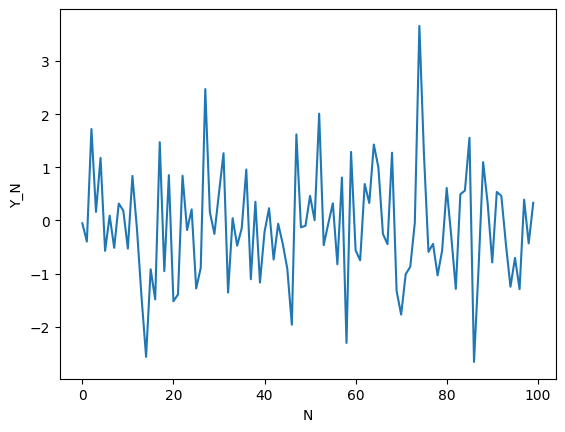

In [17]:
plt.plot(y)
plt.ylabel("Y_N")
plt.xlabel("N")
plt.show()


In [38]:
y.shape

(100,)

In [54]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    theta = Normal('theta', mu=0, sigma=(1/N), shape=N)
    # Define likelihood
    likelihood = Normal("y", mu=G(theta_0,N, args), sigma=0.5, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


/Users/doubleluckybear/Desktop/free_energy_barriers/pymc/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

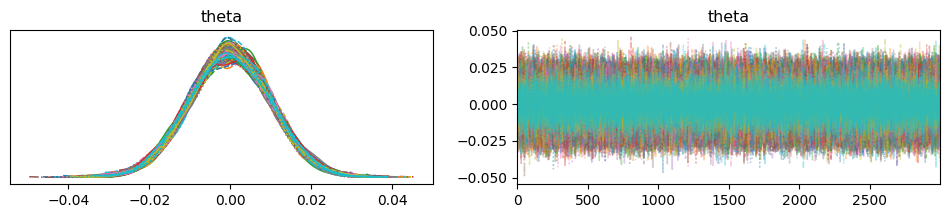

In [55]:
az.plot_trace(idata)

In [36]:
# Get posterior means (or other summary stats)
posterior_means = pm.summary(idata)
print(posterior_means)


       mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.46  20.825 -37.107   38.523        1.7    1.205     149.0     101.0   

       r_hat  
theta   1.03  


In [47]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    theta = Normal("theta", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=G(theta_0,args), sigma=sigma, observed=y)

    # Inference!
    start = {'theta': 200}
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(100, tune=0, start=start,init="adapt_diag")

/var/folders/52/zlgr2hdx7nb8f3m4970zr2v40000gn/T/ipykernel_8721/3071379094.py:11: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  idata = pm.sample(100, tune=0, start=start,init="adapt_diag")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


/Users/doubleluckybear/Desktop/free_energy_barriers/pymc/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 0 tune and 100 draw iterations (0 + 400 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

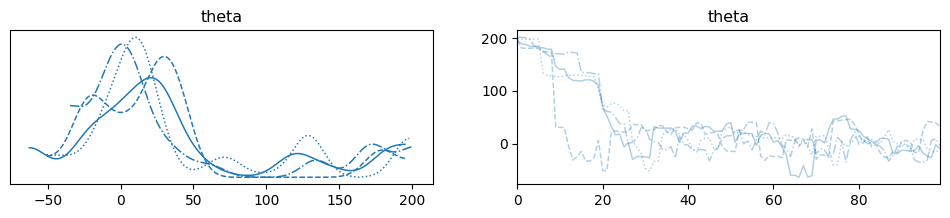

In [48]:
az.plot_trace(idata)

In [49]:
# Get posterior means (or other summary stats)
posterior_means = pm.summary(idata)
print(posterior_means)

       mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  33.5  63.341 -40.672  184.573     15.229   10.956      23.0      55.0   

       r_hat  
theta   1.13  


In [45]:
import numpy as np
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro import handlers
from jax import random

ModuleNotFoundError: No module named 'jax'